In [12]:
%load_ext autoreload
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

from simulation import gen_data, gen_corrupted_labels, add_noise_to_class
sns.set_style('whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
n_examples = 10000
p = .5
n_runs = 5

In [4]:
# Scores vs. delta 
def get_data(n_examples, n_runs, delta_0, delta_1):
    N_TRAIN = int(.5*n_examples)
    N_VAL = int(.25*n_examples)
    N_TEST = int(.25*n_examples)

    X, y = gen_data(p, n_examples=n_examples)

    X_train, y_train = X[:N_TRAIN], y[:N_TRAIN]
    X_val, y_val = X[N_TRAIN:N_TRAIN+N_VAL], y[N_TRAIN:N_TRAIN+N_VAL]
    X_test, y_test = X[N_TRAIN+N_VAL:], y[N_TRAIN+N_VAL:]
    y_train_tildes = [gen_corrupted_labels(delta_0, delta_1, y_train) for i in range(n_runs)]

    return [(X_train, y_train, y_train_tildes), (X_val,  y_val), (X_test, y_test)]
    
def score_delta(n_examples, n_runs, delta_0, delta_1):
    train, val, test = get_data(n_examples, n_runs, delta_0, delta_1)
    X_train, y_train, y_train_tildes = train
    X_val,  y_val = val
    X_test, y_test = test
    
    # Noisy LR accuracy
    avg_score = 0
    for y_train_tilde in y_train_tildes:
        lr = LogisticRegression(solver='lbfgs')
        lr.fit(X_train, y_train_tilde)
        avg_score += lr.score(X_test, y_test)*1.0/n_runs
    return avg_score

def scores_deltas(delta_vals, n_runs):
    scores = []
    for delta_0, delta_1 in delta_vals:
            scores.append(score_delta(n_examples, n_runs, delta_0, delta_1))
    return scores

# AUC vs. $\epsilon$ (Noise Rate Difference)

Text(0.5, 1.0, 'Delta* = 0.4| AUC vs. Class Noise Difference')

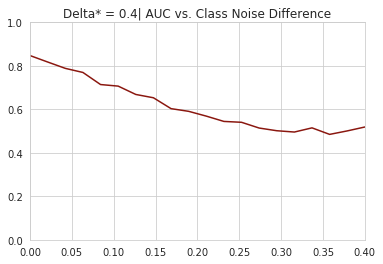

In [15]:
delta_star = .5
delta_star = .4
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .4, 20)]
scores = scores_deltas(deltas, n_runs)
scores_40 = scores

plt.plot(np.linspace(0, .4, 20), scores_40)
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.title("Delta* = " +  str(delta_star) + "| AUC vs. Class Noise Difference")

Text(0.5, 1.0, 'Delta* = 0.3 | AUC vs. Class Noise Difference')

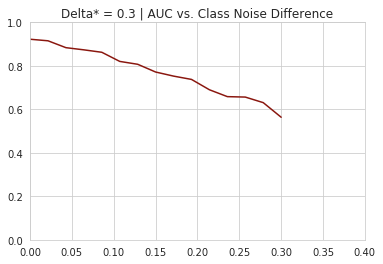

In [13]:
# delta_star = .3
delta_star = .3
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .3, 15)]
scores = scores_deltas(deltas, n_runs)
scores_30 = scores
plt.plot(np.linspace(0, .3, 15), scores)
plt.xlim(0, .4)
plt.ylim(0, 1)
plt.title("Delta* = " +  str(delta_star) + " | AUC vs. Class Noise Difference")

(0, 1)

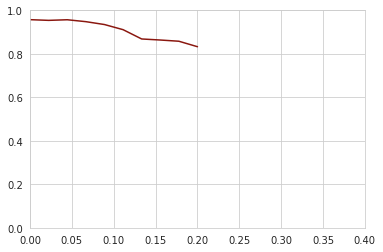

In [14]:
# delta_star = .2
delta_star = .2
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .2, 10)]
scores = scores_deltas(deltas, n_runs)
scores_20 = scores
plt.plot(np.linspace(0, .2, 10), scores_20)
plt.xlim(0, .4)
plt.ylim(0, 1)

(0, 1)

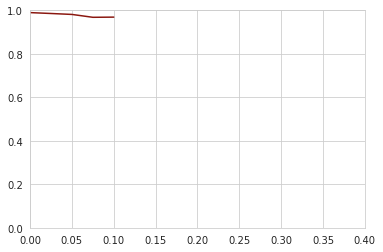

In [9]:
# delta_star = .1
delta_star = .1
deltas = [(delta_star-delta, delta_star+delta) for delta in np.linspace(0, .1, 5)]
scores = scores_deltas(deltas, n_runs)
scores_10 = scores
plt.plot(np.linspace(0, .1, 5), scores_10)
plt.xlim(0, .4)
plt.ylim(0, 1)

(0, 1)

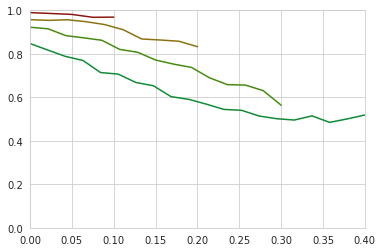

In [16]:

plt.plot(np.linspace(0, .1, 5), scores_10)
plt.plot(np.linspace(0, .2, 10), scores_20)
plt.plot(np.linspace(0, .3, 15), scores_30)
plt.plot(np.linspace(0, .4, 20), scores_40)
plt.xlim(0, .4)
plt.ylim(0, 1)

In [19]:
# Noise adding protocl
# Hypothesis: # of misclassified examples is related to difference in label error rates
# Generate data
n_runs = 1
delta_0 = .2
delta_1 = .3
train, val, test = get_data(n_examples, n_runs, delta_0, delta_1)
X_train, y_train, y_train_tildes = train
X_val,  y_val = val
X_test, y_test = test

# Identify which class suffers from more noise
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train_tildes[0])

y_pred = lr.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
val_accs = cm.diagonal()
noiseless_class = np.argmax(val_accs)
print(val_accs, noiseless_class)

raw_acc = lr.score(X_test, y_test)
print("Raw accuracy on test: ", lr.score(X_test, y_test))

delta_plus_opts = [.05, .1, .15, .2, .25, .3, .35, .4]
delta_plus_accs = []
for delta_plus in delta_plus_opts:
    y_tilde_prime = add_noise_to_class(delta_plus, noiseless_class, y_train_tildes[0])
    lr_new = LogisticRegression(solver='lbfgs')
    lr_new.fit(X_train, y_tilde_prime)
    lr_new_acc = lr_new.score(X_test, y_test)
    delta_plus_accs.append(lr_new_acc)
    print("New accuracy on test: ", lr_new_acc)

[1.         0.84397736] 0
Raw accuracy on test:  0.9168
New accuracy on test:  0.9532
New accuracy on test:  0.972
New accuracy on test:  0.9912
New accuracy on test:  0.9948
New accuracy on test:  0.9932
New accuracy on test:  0.9868
New accuracy on test:  0.9556
New accuracy on test:  0.9144


#### Notes

This could be used to 
* determine noise levels in datasets where the noise is unknown
* increase accuracy by introducing noise

Things that are necessary
* in what scenarios is this better than noise removal techniques?


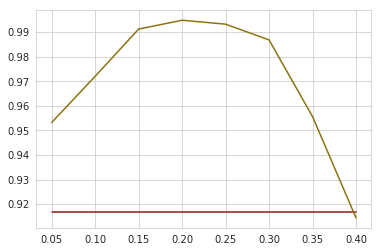

In [20]:
plt.plot(delta_plus_opts, [raw_acc for x in delta_plus_opts]) # red line: baseline accuracy, 
plt.plot(delta_plus_opts, delta_plus_accs) # gold line: accuracy after adding noise